### Dimensionality Reduction Comparison
#### Clustering Metric
The goal of this notebook is to come up with a metric that uses clustering at different levels of dimensionality to determine "nearby" interactions between cells and score transformed data based on the degree to which those distances are preserved in relation to un-reduced data.

In [1]:
import fcc_utils # this should have most of what we need for basics - PCA, tSNE, reading .hdf5 files, DCA, etc.

Using TensorFlow backend.


In [2]:
# let's also get the basics
import numpy as np
import scipy as sc
import pandas as pd

# and some extra scikit packages
import skbio
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# density peak clustering
from pydpc import Cluster

# plotting packages
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style = 'white')
%matplotlib inline

In [3]:
# read in an example dataset from Bob
%time AS1_1291 = fcc_utils.read_hdf5('inputs/Adj-Norm-1291-AS1.h5')

CPU times: user 5.19 s, sys: 2.83 s, total: 8.02 s
Wall time: 9.19 s


In [4]:
AS1_1291.keys()

dict_keys(['counts_0', 'transcripts_0'])

In [5]:
print('Counts shape: {}\nTranscript labels shape: {}\n'.format(AS1_1291['counts_0'].shape, AS1_1291['transcripts_0'].shape))

Counts shape: (17590, 38254)
Transcript labels shape: (38254,)



So this data is of shape *(n_cells, n_genes)*, and the genes are labeled nicely for us in the `AS1_1291['transcripts_0']` vector.

In [6]:
# let's take a subset of this data so it isn't too computationally expensive
AS1_1291_1 = AS1_1291['counts_0'][np.random.choice(AS1_1291['counts_0'].shape[0], size=200)]

AS1_1291_1.shape # confirm it's the right shape = (size, 32854)

(200, 38254)

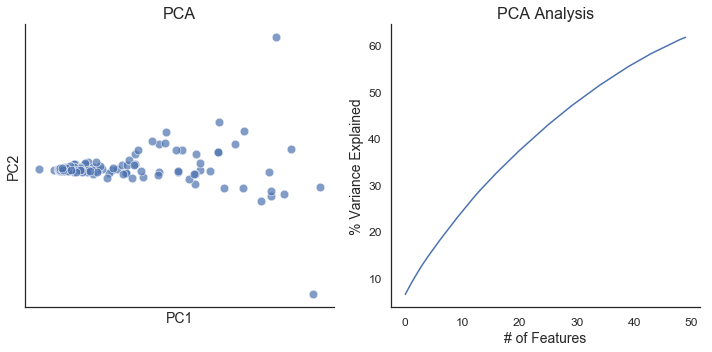

In [7]:
# normalize counts data using arcsinh transformation
AS1_1291_1_norm = fcc_utils.arcsinh_norm(AS1_1291_1, norm=True, scale=1000)

# perform PCA on subsampled data with 50 components
AS1_1291_1_PCA = fcc_utils.fcc_PCA(x=AS1_1291_1_norm, n_comp=50)

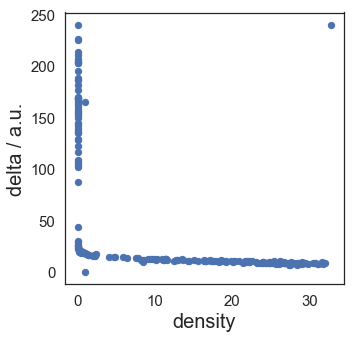

In [8]:
clu = Cluster(AS1_1291_1_PCA) # cluster using pydpc

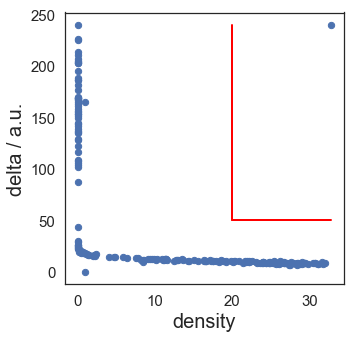

In [9]:
clu.assign(20,50) # assign cluster centers; looks like there's only one for this dataset

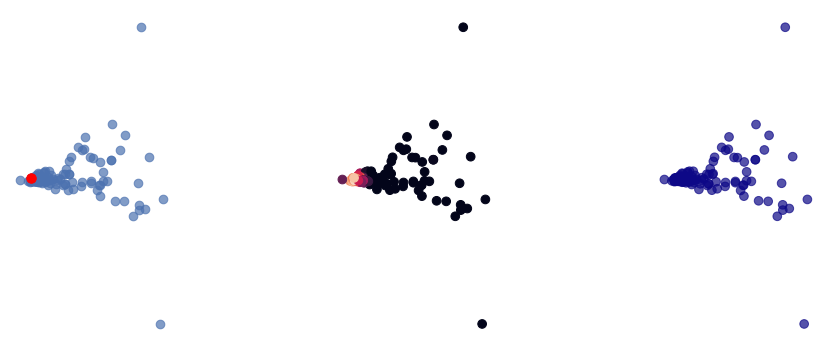

In [11]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(AS1_1291_1_PCA[:, 0], AS1_1291_1_PCA[:, 1], s=75, alpha=0.7)
ax[0].scatter(AS1_1291_1_PCA[clu.clusters, 0], AS1_1291_1_PCA[clu.clusters, 1], s=90, c="red")
ax[1].scatter(AS1_1291_1_PCA[:, 0], AS1_1291_1_PCA[:, 1], s=75, c=clu.density)
ax[2].scatter(AS1_1291_1_PCA[:, 0], AS1_1291_1_PCA[:, 1], s=75, c=clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

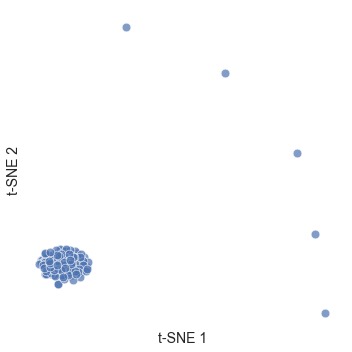

CPU times: user 1.22 s, sys: 28.7 ms, total: 1.24 s
Wall time: 1.16 s


In [12]:
# Now perform t-SNE on PCA output
# This uses perplexity=30 (default) and random initialisation
%time AS1_1291_1_tSNE = fcc_utils.fcc_tSNE(AS1_1291_1_PCA)

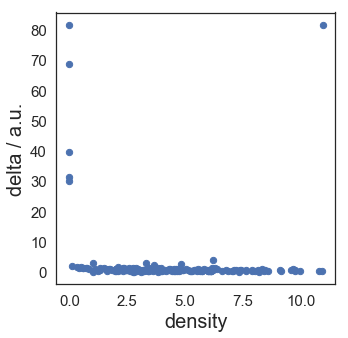

In [13]:
std_clu = Cluster(AS1_1291_1_tSNE.astype('double')) # cluster using pydpc

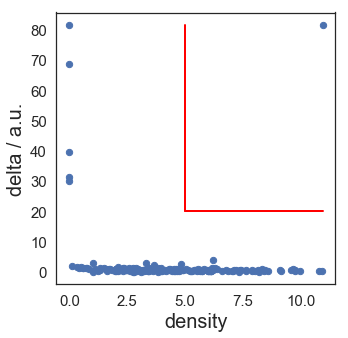

In [14]:
std_clu.assign(5,20) # assign cluster centers; looks like there's only one for this dataset

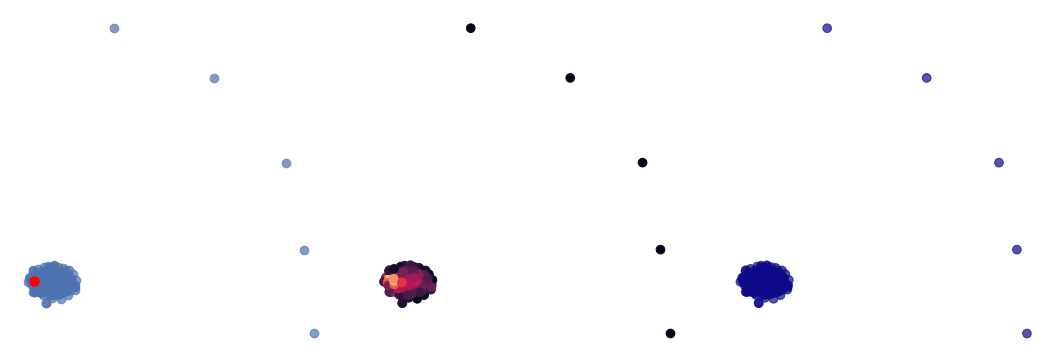

In [15]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(AS1_1291_1_tSNE[:, 0], AS1_1291_1_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(AS1_1291_1_tSNE[std_clu.clusters, 0], AS1_1291_1_tSNE[std_clu.clusters, 1], s=90, c="red")
ax[1].scatter(AS1_1291_1_tSNE[:, 0], AS1_1291_1_tSNE[:, 1], s=75, c=std_clu.density)
ax[2].scatter(AS1_1291_1_tSNE[:, 0], AS1_1291_1_tSNE[:, 1], s=75, c=std_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

---
#### Look at DCA results
Perform DCA on the raw data prior to processing to check for improvements in noise

In [16]:
%time AS1_1291_1_DCA = fcc_utils.fcc_DCA(AS1_1291_1)

DCA: Successfully preprocessed 13005 genes and 200 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 1min 14s, sys: 15.6 s, total: 1min 29s
Wall time: 44.2 s


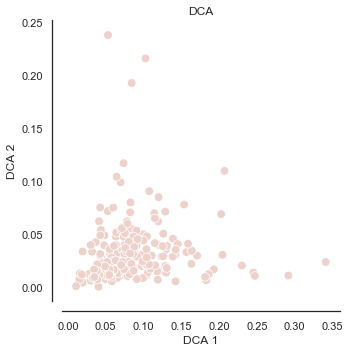

In [17]:
# look at first two components of DCA, colored using PCA-tSNE clusters
plt.figure(figsize=(5,5))

sns.scatterplot(AS1_1291_1_DCA[:,0], AS1_1291_1_DCA[:,1], s=75, hue=std_clu.membership, legend=False)
plt.title('DCA')
plt.xlabel('DCA 1')
plt.ylabel('DCA 2')

sns.despine(offset=10)
plt.tight_layout()

This doesn't mean anything.  I don't think the 33 DCA components are rank-ordered.  Better perform PCA or t-SNE to visualize.

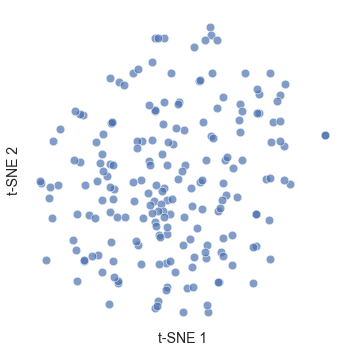

CPU times: user 1.87 s, sys: 38 ms, total: 1.91 s
Wall time: 1.82 s


In [18]:
# perform tSNE on DCA-denoised raw data
%time AS1_1291_1_DCA_tSNE = fcc_utils.fcc_tSNE(AS1_1291_1_DCA)

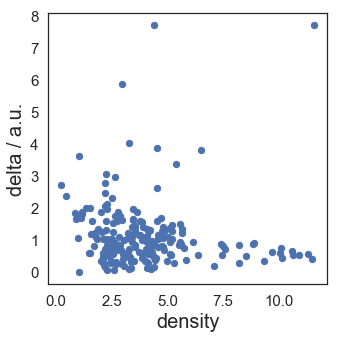

In [19]:
dca_clu = Cluster(AS1_1291_1_DCA_tSNE.astype('double')) # cluster using pydpc

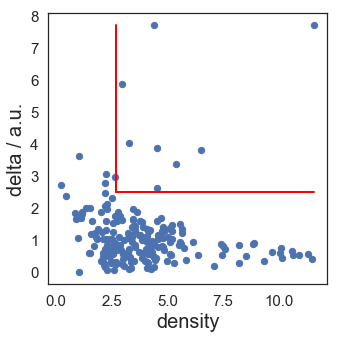

In [24]:
dca_clu.assign(2.7,2.5) # assign cluster centers

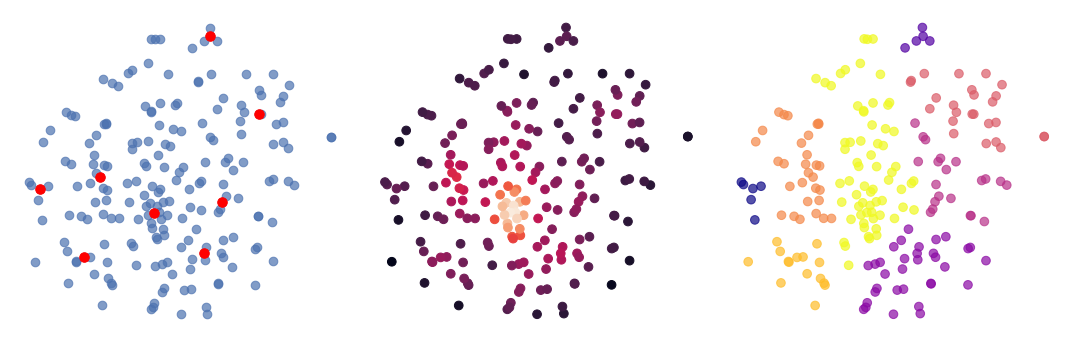

In [25]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(AS1_1291_1_DCA_tSNE[:, 0], AS1_1291_1_DCA_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(AS1_1291_1_DCA_tSNE[dca_clu.clusters, 0], AS1_1291_1_DCA_tSNE[dca_clu.clusters, 1], s=90, c="red")
ax[1].scatter(AS1_1291_1_DCA_tSNE[:, 0], AS1_1291_1_DCA_tSNE[:, 1], s=75, c=dca_clu.density)
ax[2].scatter(AS1_1291_1_DCA_tSNE[:, 0], AS1_1291_1_DCA_tSNE[:, 1], s=75, c=dca_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [26]:
# calculate silhouette score for clustered results
silhouette_score(AS1_1291_1_DCA_tSNE, dca_clu.membership)

0.24390055

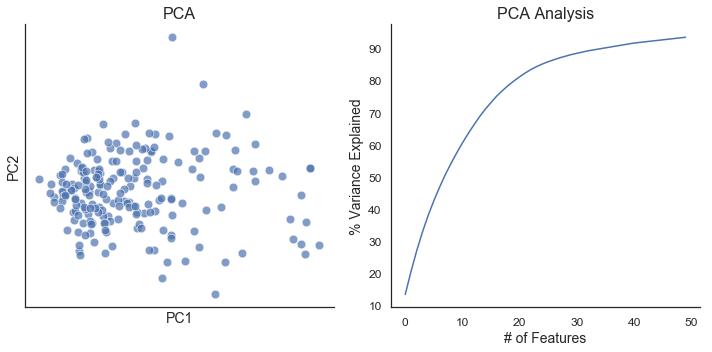

CPU times: user 838 ms, sys: 67.5 ms, total: 906 ms
Wall time: 547 ms


In [27]:
# perform 50-component PCA on DCA-primed dataset for visualization
%time AS1_1291_1_DCA_PCA = fcc_utils.fcc_PCA(AS1_1291_1_DCA, n_comp=50)

Now perform t-SNE on DCA-denoised, PCA-primed data to check for any improvement.

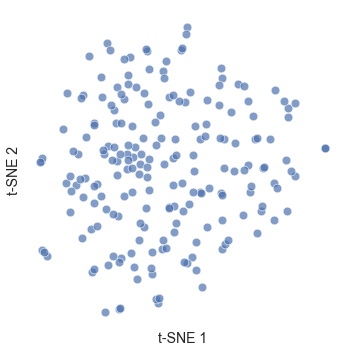

CPU times: user 1.11 s, sys: 24.3 ms, total: 1.13 s
Wall time: 1.04 s


In [28]:
# perform tSNE on DCA-PCA output
%time AS1_1291_1_DCA_PCA_tSNE = fcc_utils.fcc_tSNE(AS1_1291_1_DCA_PCA)

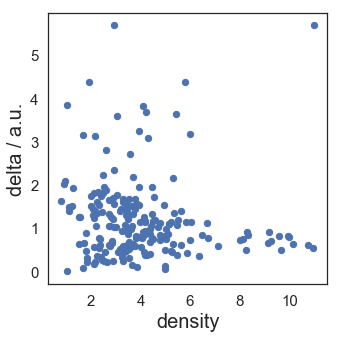

In [29]:
dca_pca_clu = Cluster(AS1_1291_1_DCA_PCA_tSNE.astype('double')) # cluster using pydpc

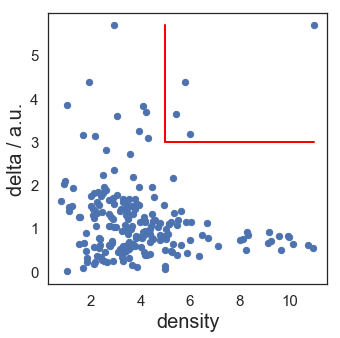

In [30]:
dca_pca_clu.assign(5,3) # assign cluster centers; looks like there's only one for this dataset

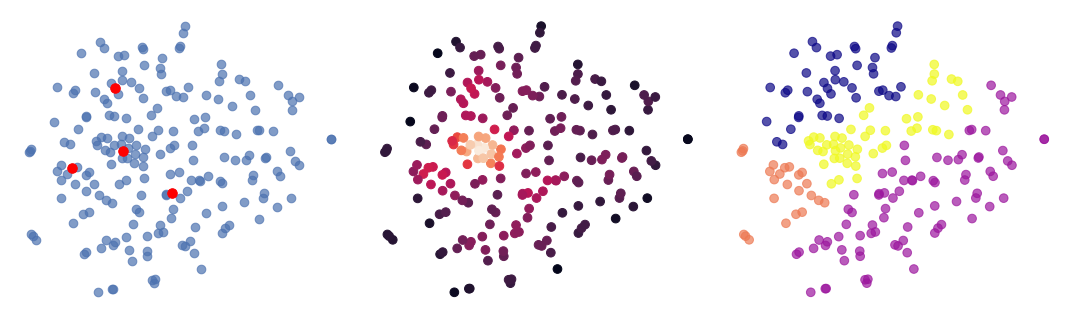

In [31]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(AS1_1291_1_DCA_PCA_tSNE[:, 0], AS1_1291_1_DCA_PCA_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(AS1_1291_1_DCA_PCA_tSNE[dca_pca_clu.clusters, 0], AS1_1291_1_DCA_PCA_tSNE[dca_pca_clu.clusters, 1], s=90, c="red")
ax[1].scatter(AS1_1291_1_DCA_PCA_tSNE[:, 0], AS1_1291_1_DCA_PCA_tSNE[:, 1], s=75, c=dca_pca_clu.density)
ax[2].scatter(AS1_1291_1_DCA_PCA_tSNE[:, 0], AS1_1291_1_DCA_PCA_tSNE[:, 1], s=75, c=dca_pca_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [32]:
# calculate silhouette score for clustered results
silhouette_score(AS1_1291_1_DCA_PCA_tSNE, dca_pca_clu.membership)

0.20074736

---
##### Distance Metrics
Let's look at different 'distance' calculations and compare them to one another

In [39]:
%%time
# first, get upper triangle of distance matrices for PCA-tSNE and DCA-PCA-tSNE
dm_pre = sc.spatial.distance_matrix(AS1_1291_1_PCA,AS1_1291_1_PCA)
dm_post = sc.spatial.distance_matrix(AS1_1291_1_tSNE,AS1_1291_1_tSNE)

# for each matrix, take the upper triangle (it's symmetrical) for calculating EMD and plotting distance differences
pre_flat = dm_pre[np.triu_indices(dm_pre.shape[1],1)]
post_flat = dm_post[np.triu_indices(dm_post.shape[1],1)]

# normalize flattened distances within each set for fair comparison regardless of raw values
pre_flat = (pre_flat/pre_flat.max())
post_flat = (post_flat/post_flat.max())

CPU times: user 335 ms, sys: 10.3 ms, total: 346 ms
Wall time: 355 ms


In [40]:
# perform mantel test on distance matrices
skbio.stats.distance.mantel(x=dm_pre, y=dm_post)

(0.35702038073442094, 0.001, 200)

Length of flattened upper triangle 1: 19900
Length of flattened upper triangle 2: 19900
Expected length: 244650.0


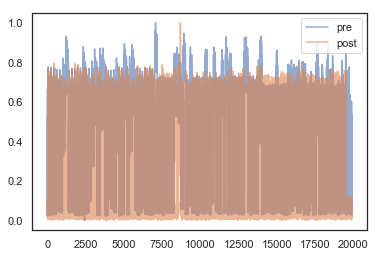

In [42]:
# check lengths of unique cell-cell distances
print('Length of flattened upper triangle 1: {}'.format(len(pre_flat)))
print('Length of flattened upper triangle 2: {}'.format(len(post_flat)))
print('Expected length: {}'.format((700**2-700)/2))

# plot unique cell-cell distances
plt.plot(pre_flat, alpha=0.6, label='pre')
plt.plot(post_flat, alpha=0.6, label='post')
plt.legend(loc='best')

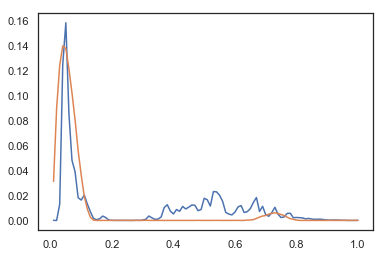

In [43]:
# calculate and plot the probability distributions for cell-cell distances in each t-SNE projection
num_bins = 100
pre_counts, pre_bin_edges = np.histogram (pre_flat, bins=num_bins)
post_counts, post_bin_edges = np.histogram (post_flat, bins=num_bins)

plt.plot(pre_bin_edges[1:], pre_counts/sum(pre_counts))
plt.plot(post_bin_edges[1:], post_counts/sum(post_counts))

Now, get the cumulative distribution functions for each distance matrix and plot them

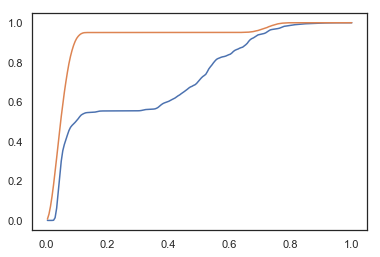

In [44]:
# calculate and plot the cumulative probability distributions for cell-cell distances in each t-SNE projection
num_bins = int(len(pre_flat)/100)

pre_counts, pre_bin_edges = np.histogram (pre_flat, bins=num_bins)
pre_cdf = np.cumsum (pre_counts)

post_counts, post_bin_edges = np.histogram (post_flat, bins=num_bins)
post_cdf = np.cumsum (post_counts)

plt.plot(pre_bin_edges[1:], pre_cdf/pre_cdf[-1])
plt.plot(post_bin_edges[1:], post_cdf/post_cdf[-1])

In [45]:
# I think this is the Kolmogorov-Smirnov distance...
# maximum absolute difference between the two empirical CDFs evaluated at any point
# TODO: fix this, it's wrong
max(pre_cdf/pre_cdf[-1] - post_cdf/post_cdf[-1])

0.0

The **Wasserstein** or **Earth-Mover's Distance** is defined as the sum of the differences between the two CDFs 

In [46]:
# Earth mover's distance
sc.stats.wasserstein_distance(pre_flat, post_flat)

0.1972994810326747

In [47]:
# Kullback Leibler divergence
# add very small number to avoid dividing by zero
sc.stats.entropy(pre_flat+0.00000001, post_flat+0.00000001)

0.6599703381471518

In [48]:
# energy distance
# TODO: find out what this is
sc.stats.energy_distance(post_flat, pre_flat)

0.3639000703474767

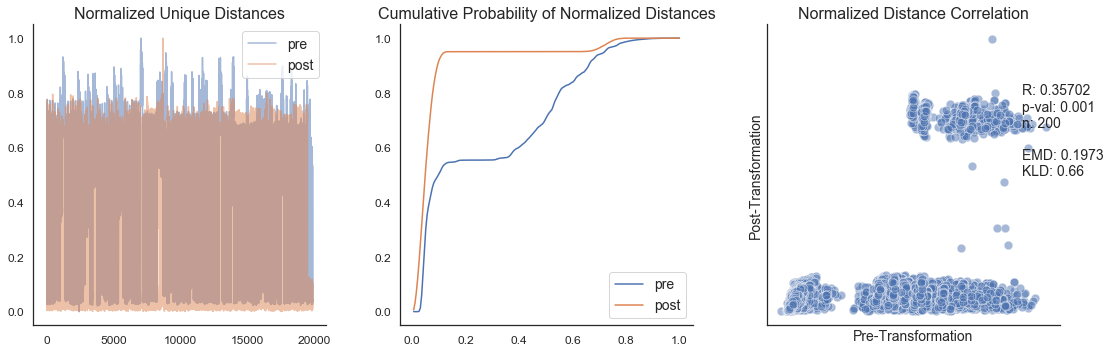

CPU times: user 1.92 s, sys: 114 ms, total: 2.03 s
Wall time: 1.46 s


In [49]:
# correlate cell-cell distances between normal PCA and PCA-tSNE output using function to compare to above results
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=AS1_1291_1_PCA, post=AS1_1291_1_tSNE)

So, the function `fcc_utils.compare_euclid()` works properly, as the graphical outputs are the same as manual analysis.

---
Now, let's use it for other combinations of DR as performed above.

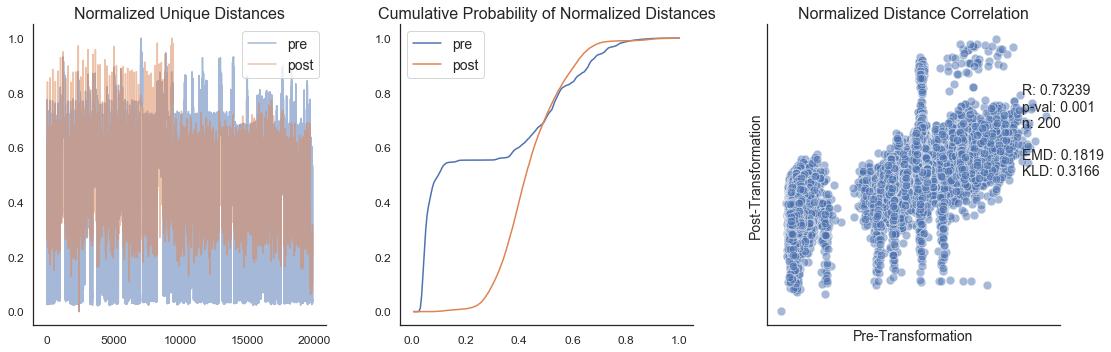

CPU times: user 2.75 s, sys: 357 ms, total: 3.11 s
Wall time: 2.54 s


In [50]:
# correlate cell-cell distances between normal PCA and DCA output
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=AS1_1291_1_PCA, post=AS1_1291_1_DCA)

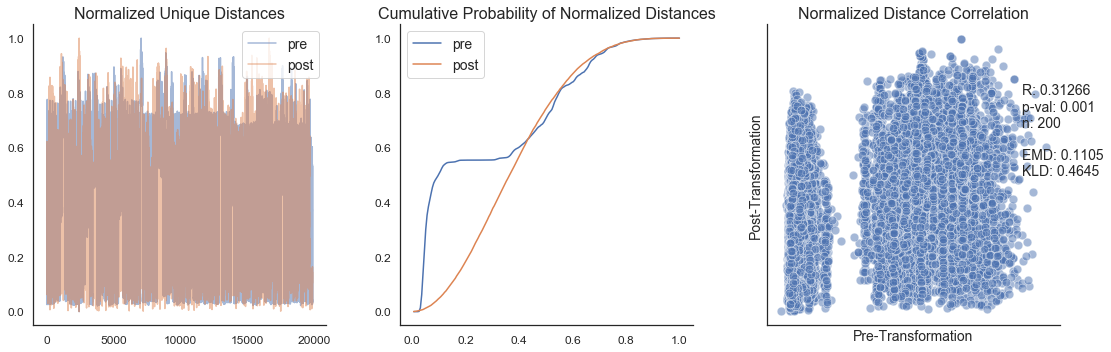

CPU times: user 2.12 s, sys: 129 ms, total: 2.25 s
Wall time: 1.67 s


In [53]:
# correlate cell-cell distances between normal PCA and DCA-tSNE
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=AS1_1291_1_PCA, post=AS1_1291_1_DCA_tSNE)

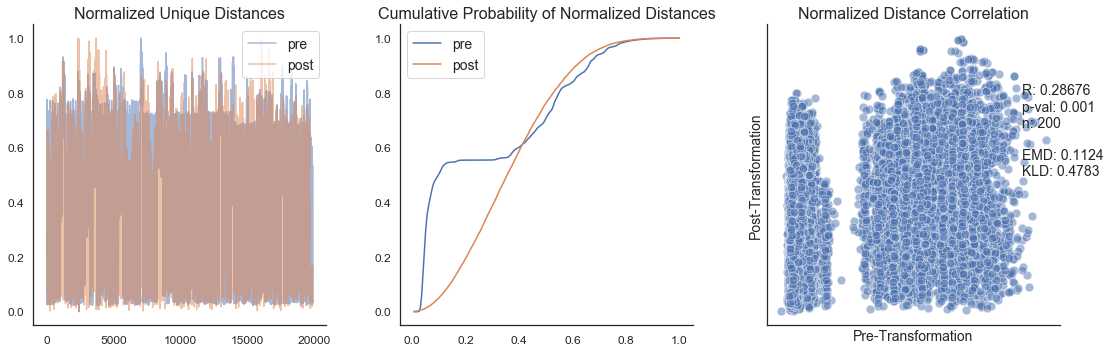

CPU times: user 2.08 s, sys: 122 ms, total: 2.21 s
Wall time: 1.61 s


In [54]:
# correlate cell-cell distances between normal PCA and DCA-PCA-tSNE
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=AS1_1291_1_PCA, post=AS1_1291_1_DCA_PCA_tSNE)

---
Read in another dataset from scVI example data to see if we get better clustering

In [55]:
umi_rna = pd.read_csv('inputs/GSE100866_CBMC_8K_13AB_10X-RNA_umi.csv',index_col=0)
umi_rna

,Barcode1,Barcode2,Barcode3,Barcode4,Barcode5,Barcode6,Barcode7,Barcode8,Barcode9,Barcode10,...,Barcode41,Barcode42,Barcode43,Barcode44,Barcode45,Barcode46,Barcode47,Barcode48,Barcode49,Barcode50
MOUSE_ACTB,243,410,321,351,534,221,630,220,142,304,...,225,189,173,1474,245,140,245,467,2205,250
MOUSE_CCL2,4,1853,2,0,25,59,1,24,21,4,...,0,5,2,8,23,1,21,0,3,6
MOUSE_MALAT1,757,579,543,575,734,426,283,487,422,529,...,346,349,705,1054,355,860,317,387,1056,342
MOUSE_S100A6,863,233,562,870,657,773,1069,826,1017,889,...,963,335,1085,393,732,365,581,875,249,489
MOUSE_TMSB4X,368,995,300,527,467,306,274,112,298,395,...,474,247,197,441,246,124,459,273,285,428
MOUSE_LGALS1,940,530,1094,1056,684,1028,1151,951,1135,857,...,855,686,892,736,899,353,686,799,337,751
MOUSE_FTH1,293,386,351,257,760,291,565,293,561,426,...,451,387,569,275,346,531,372,380,990,355
MOUSE_ACTA2,69,547,82,27,575,204,31,8,46,58,...,97,35,3,218,105,7,2,141,166,7
MOUSE_MT-ND1,403,943,451,426,731,447,515,392,588,632,...,432,697,460,443,539,558,641,329,971,470
MOUSE_MT-CYTB,341,597,315,362,570,340,460,277,453,505,...,267,486,310,235,427,433,394,292,438,365


In [56]:
# extract data from pandas dataframe as np.ndarray
umi_rna_vals = np.ascontiguousarray(umi_rna.values.T, dtype='double')

# normalize counts data using arcsinh transformation
umi_rna_norm = fcc_utils.arcsinh_norm(umi_rna_vals, norm=True, scale=1000)

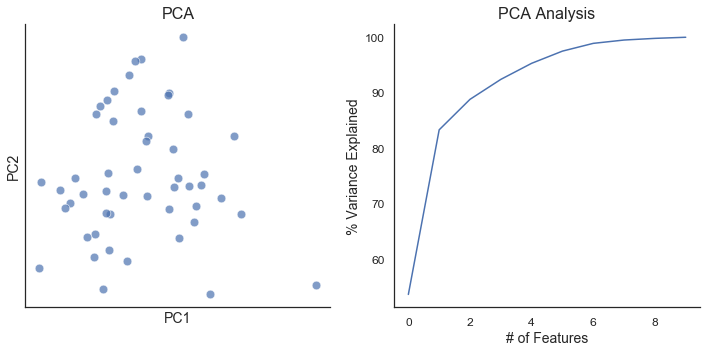

In [58]:
# Perform PCA. Only use 10 components because there's only 10 samples.
umi_rna_PCA = fcc_utils.fcc_PCA(x=umi_rna_norm, n_comp=10)

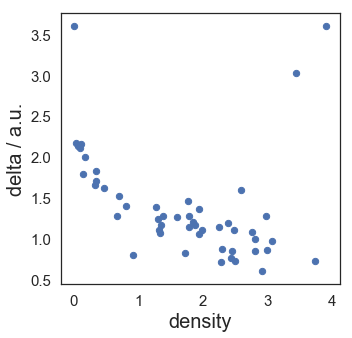

In [59]:
umi_pca_clu = Cluster(umi_rna_PCA) # perform density peak clustering on PCA for umi dataset

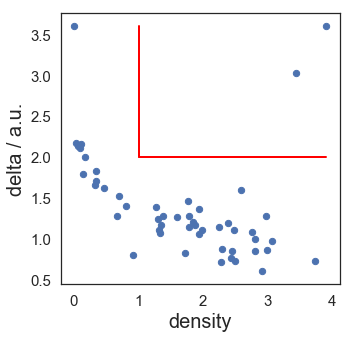

In [60]:
umi_pca_clu.assign(1,2) # assign cluster centers; looks like there's only one for this dataset

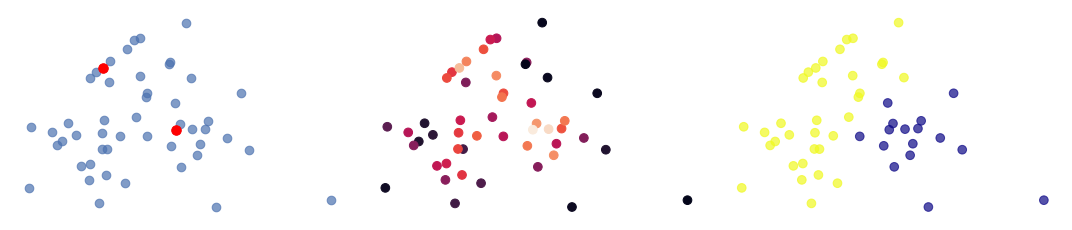

In [61]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(umi_rna_PCA[:, 0], umi_rna_PCA[:, 1], s=75, alpha=0.7)
ax[0].scatter(umi_rna_PCA[umi_pca_clu.clusters, 0], umi_rna_PCA[umi_pca_clu.clusters, 1], s=90, c="red")
ax[1].scatter(umi_rna_PCA[:, 0], umi_rna_PCA[:, 1], s=75, c=umi_pca_clu.density)
ax[2].scatter(umi_rna_PCA[:, 0], umi_rna_PCA[:, 1], s=75, c=umi_pca_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [84]:
# calculate silhouette score for clustered results
silhouette_score(umi_rna_PCA, umi_pca_clu.membership)

0.30193379513656066

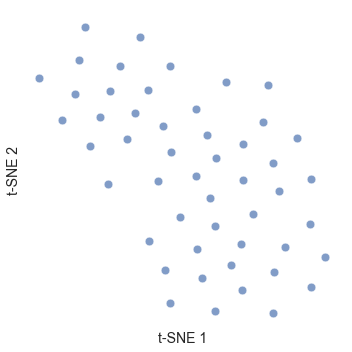

In [62]:
# perform tSNE on umi_rna PCA results
umi_rna_tSNE = fcc_utils.fcc_tSNE(x=umi_rna_PCA)

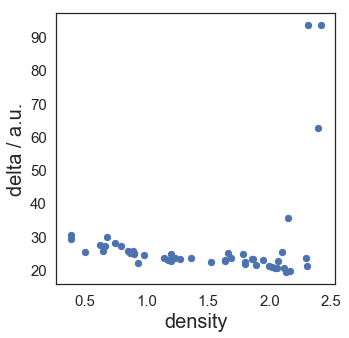

In [64]:
umi_tsne_clu = Cluster(umi_rna_tSNE.astype('double')) # perform density peak clustering on PCA for umi dataset

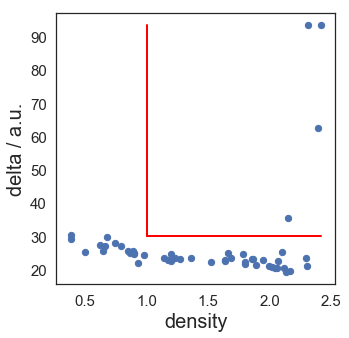

In [65]:
umi_tsne_clu.assign(1,30) # assign cluster centers; looks like there's only one for this dataset

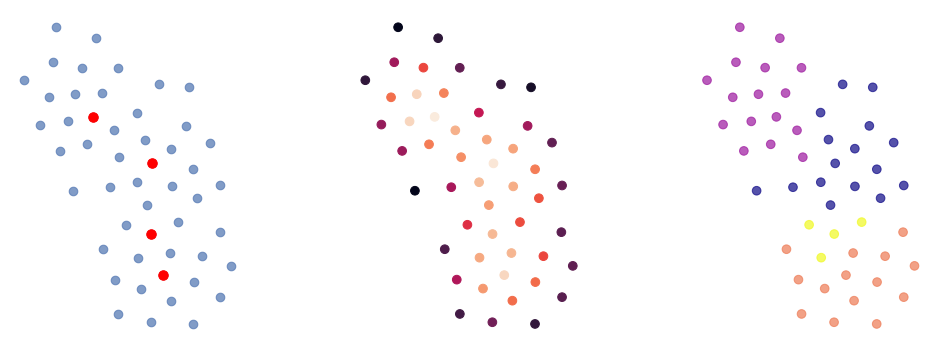

In [66]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(umi_rna_tSNE[:, 0], umi_rna_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(umi_rna_tSNE[umi_tsne_clu.clusters, 0], umi_rna_tSNE[umi_tsne_clu.clusters, 1], s=90, c="red")
ax[1].scatter(umi_rna_tSNE[:, 0], umi_rna_tSNE[:, 1], s=75, c=umi_tsne_clu.density)
ax[2].scatter(umi_rna_tSNE[:, 0], umi_rna_tSNE[:, 1], s=75, c=umi_tsne_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [83]:
# calculate silhouette score for clustered results
silhouette_score(umi_rna_tSNE, umi_tsne_clu.membership)

0.22204499

So this dataset has better clustering on its PCA than a t-SNE...

---
Read in another dataset from **p-Creode** example data to see if we get better clustering

In [68]:
myeloid = pd.read_csv('inputs/Myeloid_with_IDs.csv')

In [69]:
# extract data from pandas dataframe as np.ndarray
myeloid_vals = np.ascontiguousarray(myeloid.values.T, dtype='double')

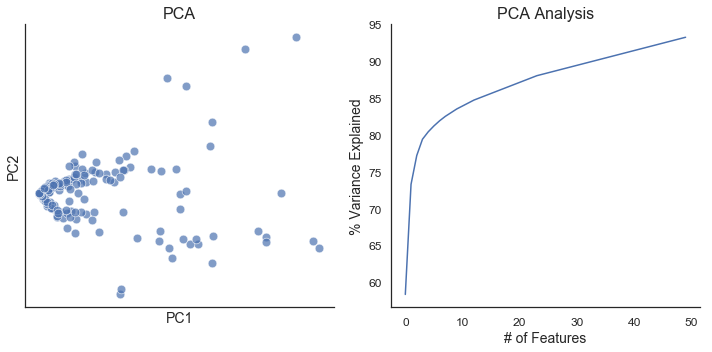

In [72]:
# perform PCA
myeloid_PCA = fcc_utils.fcc_PCA(myeloid_vals, n_comp=50)

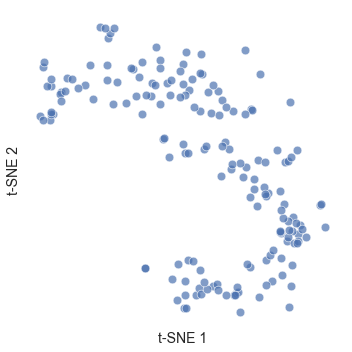

CPU times: user 999 ms, sys: 34.1 ms, total: 1.03 s
Wall time: 867 ms


In [74]:
# perform t-SNE on these data 
%time myeloid_tSNE = fcc_utils.fcc_tSNE(myeloid_PCA)

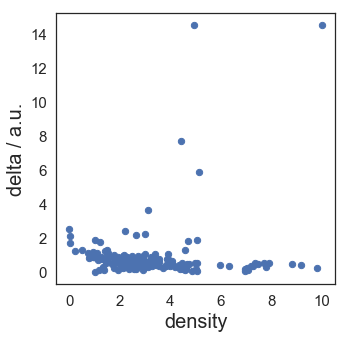

In [77]:
myeloid_tsne_clu = Cluster(myeloid_tSNE.astype('double')) # perform density peak clustering on tSNE for myeloid dataset

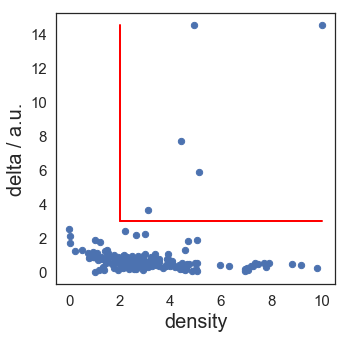

In [78]:
myeloid_tsne_clu.assign(2,3) # assign cluster centers; looks like there's only one for this dataset

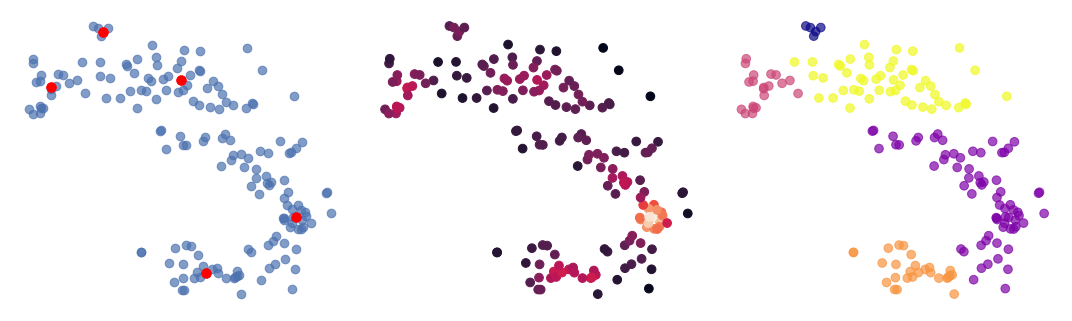

In [80]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(myeloid_tSNE[myeloid_tsne_clu.clusters, 0], myeloid_tSNE[myeloid_tsne_clu.clusters, 1], s=90, c="red")
ax[1].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, c=myeloid_tsne_clu.density)
ax[2].scatter(myeloid_tSNE[:, 0], myeloid_tSNE[:, 1], s=75, c=myeloid_tsne_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [82]:
# calculate silhouette score for clustered results
silhouette_score(myeloid_tSNE, myeloid_tsne_clu.membership)

0.38444752

---
Read in another dataset with easy clustering to see if these metrics still work

In [90]:
r00 = np.genfromtxt('inputs/little_test.csv', delimiter=',')

In [91]:
r00.shape

(375, 25507)

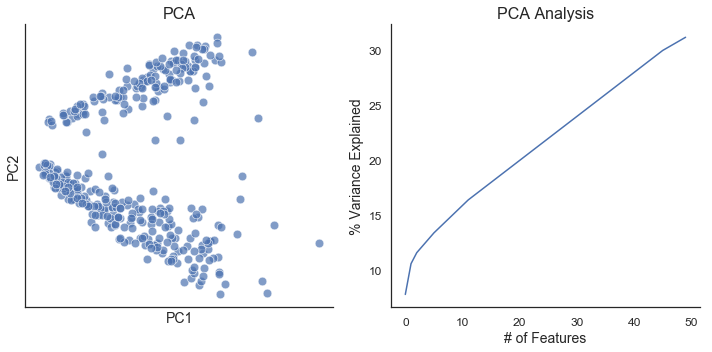

In [93]:
r00_norm = fcc_utils.arcsinh_norm(r00) # normalize first

r00_PCA = fcc_utils.fcc_PCA(r00_norm, n_comp=50) # perform PCA

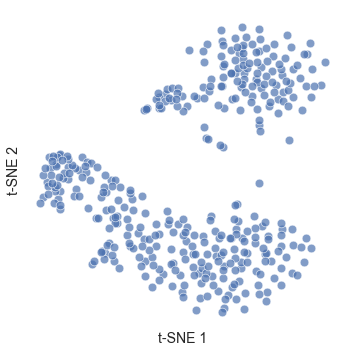

In [94]:
r00_tSNE = fcc_utils.fcc_tSNE(r00_PCA) # perform t-SNE

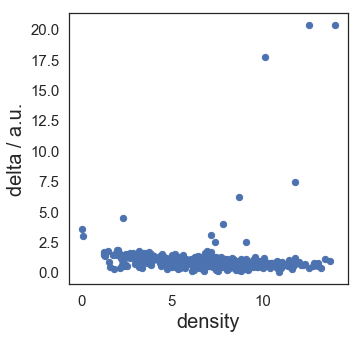

In [96]:
r00_tsne_clu = Cluster(r00_tSNE.astype('float'))

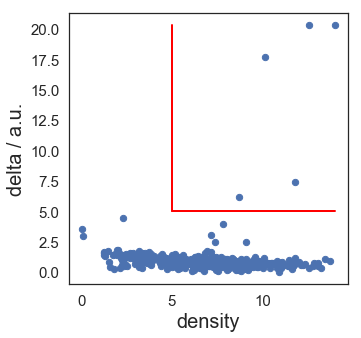

In [97]:
r00_tsne_clu.assign(5,5)

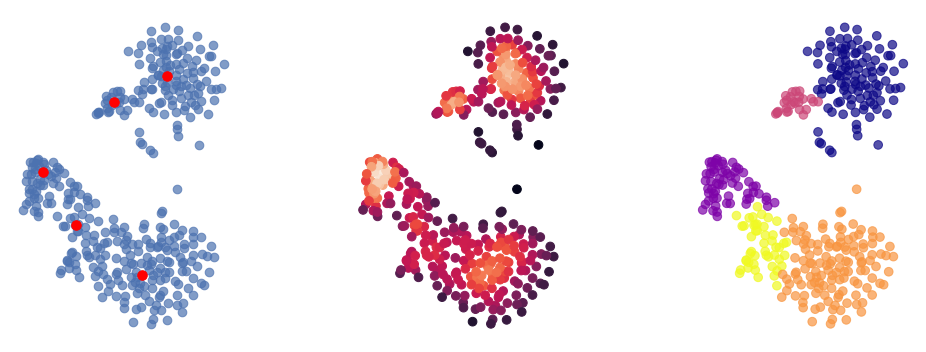

In [98]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(r00_tSNE[:, 0], r00_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(r00_tSNE[r00_tsne_clu.clusters, 0], r00_tSNE[r00_tsne_clu.clusters, 1], s=90, c="red")
ax[1].scatter(r00_tSNE[:, 0], r00_tSNE[:, 1], s=75, c=r00_tsne_clu.density)
ax[2].scatter(r00_tSNE[:, 0], r00_tSNE[:, 1], s=75, c=r00_tsne_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [99]:
# calculate silhouette score for clustered results
silhouette_score(r00_tSNE, r00_tsne_clu.membership)

0.42782182

---
Perform DCA on the raw data prior to processing to check for improvements in noise

In [100]:
%time r00_DCA = fcc_utils.fcc_DCA(r00)

DCA: Successfully preprocessed 21245 genes and 375 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 2min 29s, sys: 32.9 s, total: 3min 2s
Wall time: 1min 29s


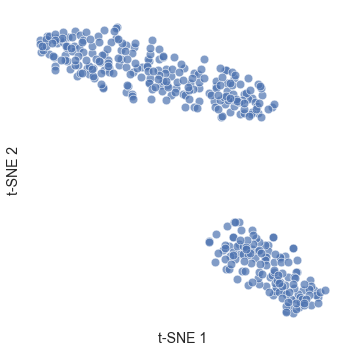

CPU times: user 5.71 s, sys: 79.7 ms, total: 5.79 s
Wall time: 5.77 s


In [101]:
# perform tSNE on DCA-denoised raw data
%time r00_DCA_tSNE = fcc_utils.fcc_tSNE(r00_DCA)

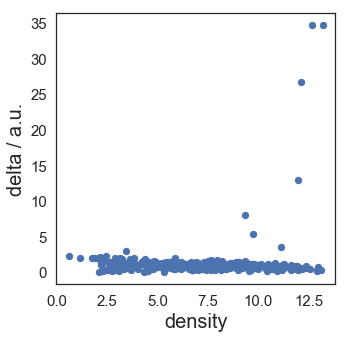

In [102]:
r00_dca_clu = Cluster(r00_DCA_tSNE.astype('double')) # cluster using pydpc

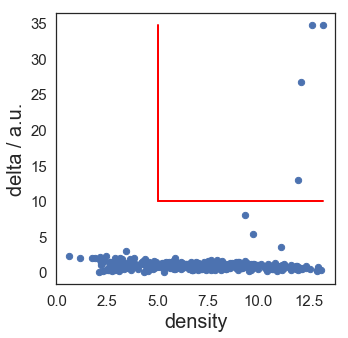

In [107]:
r00_dca_clu.assign(5,10) # assign cluster centers

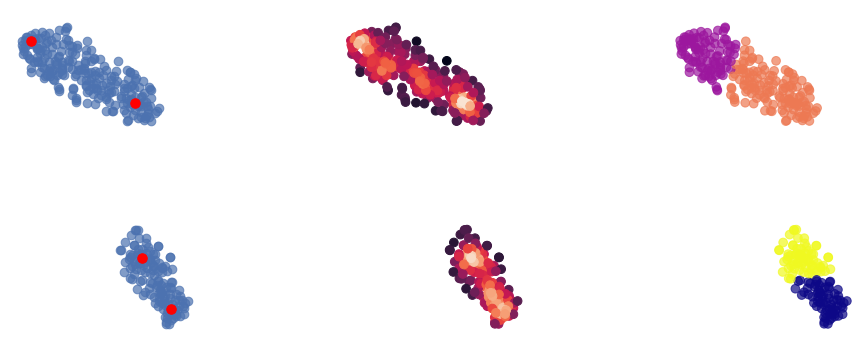

In [108]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(r00_DCA_tSNE[:, 0], r00_DCA_tSNE[:, 1], s=75, alpha=0.7)
ax[0].scatter(r00_DCA_tSNE[r00_dca_clu.clusters, 0], r00_DCA_tSNE[r00_dca_clu.clusters, 1], s=90, c="red")
ax[1].scatter(r00_DCA_tSNE[:, 0], r00_DCA_tSNE[:, 1], s=75, c=r00_dca_clu.density)
ax[2].scatter(r00_DCA_tSNE[:, 0], r00_DCA_tSNE[:, 1], s=75, c=r00_dca_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [109]:
# calculate silhouette score for clustered results
silhouette_score(r00_DCA_tSNE, r00_dca_clu.membership)

0.5377143

---
So DCA-tSNE has an improvement in clustering over PCA-tSNE for this dataset based on silhouette score.  
Let's compare the cell-cell distances for these projections.

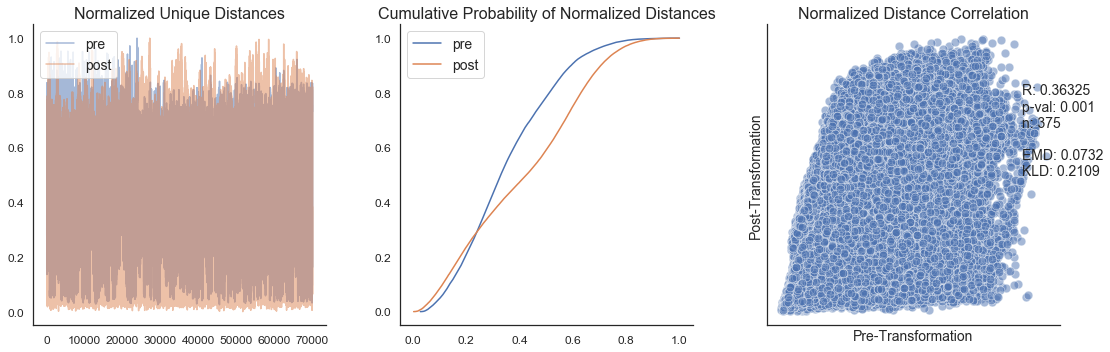

CPU times: user 4.1 s, sys: 163 ms, total: 4.26 s
Wall time: 3.62 s


In [110]:
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=r00_PCA, post=r00_tSNE) # compare distances for tSNE to PCA

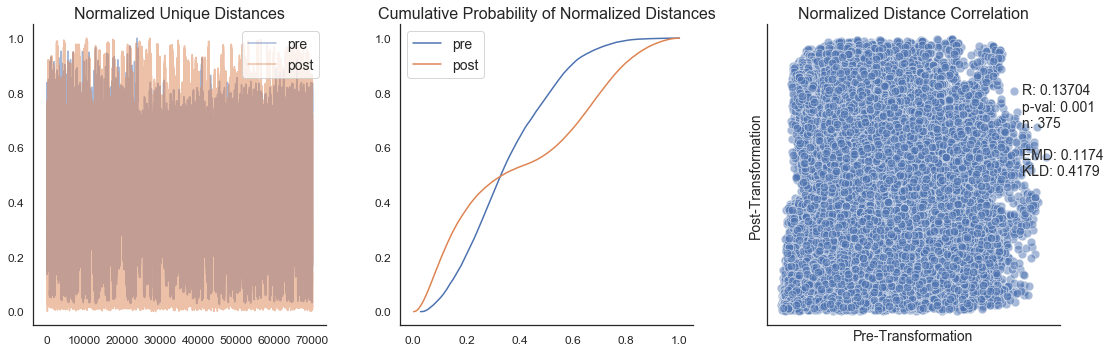

CPU times: user 4.15 s, sys: 171 ms, total: 4.32 s
Wall time: 3.7 s


In [111]:
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=r00_PCA, post=r00_DCA_tSNE) 

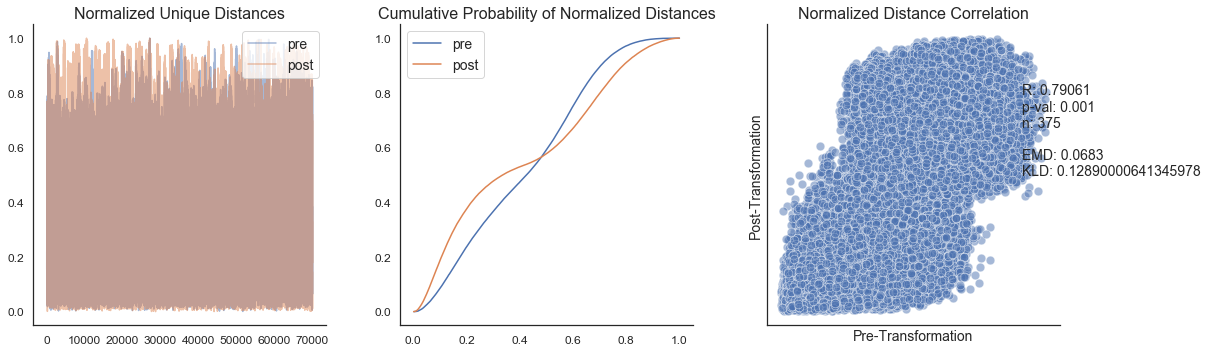

CPU times: user 4.25 s, sys: 204 ms, total: 4.46 s
Wall time: 3.9 s


In [112]:
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=r00_tSNE, post=r00_DCA_tSNE) 

---
Now try UMAP 

In [114]:
import umap

In [115]:
r00_umap = umap.UMAP(n_neighbors=30,min_dist=0.3,metric='correlation').fit_transform(r00_PCA)

In [116]:
r00_umap.shape

(375, 2)

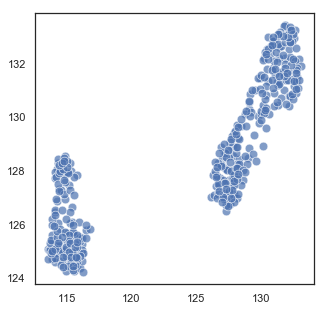

In [117]:
plt.figure(figsize=(5,5))

sns.scatterplot(r00_umap[:,0], r00_umap[:,1], s=75, alpha=0.7)

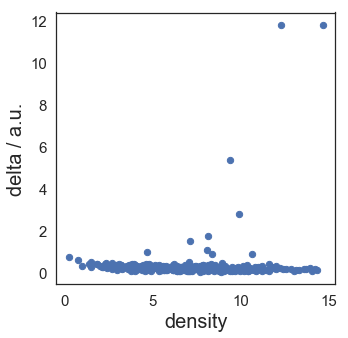

In [119]:
r00_umap_clu = Cluster(r00_umap.astype('double')) # cluster using pydpc

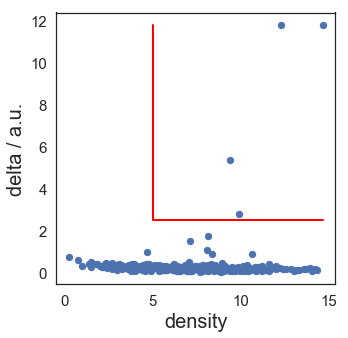

In [120]:
r00_umap_clu.assign(5,2.5) # assign cluster centers

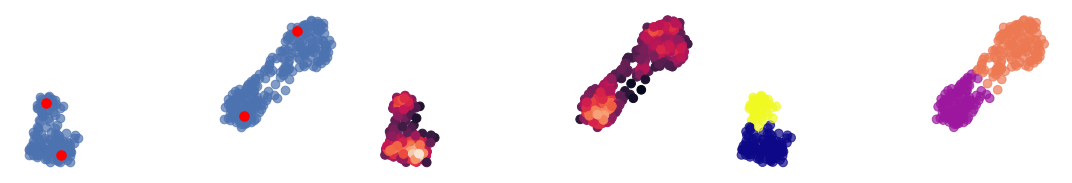

In [121]:
# plot clusters with point densities
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].scatter(r00_umap[:, 0], r00_umap[:, 1], s=75, alpha=0.7)
ax[0].scatter(r00_umap[r00_umap_clu.clusters, 0], r00_umap[r00_umap_clu.clusters, 1], s=90, c="red")
ax[1].scatter(r00_umap[:, 0], r00_umap[:, 1], s=75, c=r00_umap_clu.density)
ax[2].scatter(r00_umap[:, 0], r00_umap[:, 1], s=75, c=r00_umap_clu.membership, cmap=plt.cm.plasma, alpha=0.7)
for _ax in ax:
    _ax.tick_params(labelsize=15)
    _ax.set_aspect('equal')
    _ax.tick_params(labelbottom=False, labelleft=False)

sns.despine(left=True, bottom=True)
fig.tight_layout()

In [122]:
# calculate silhouette score for clustered results
silhouette_score(r00_umap, r00_umap_clu.membership)

0.6165565

So PCA-UMAP has the best clustering by sihouette score. Let's look at distance correlation.

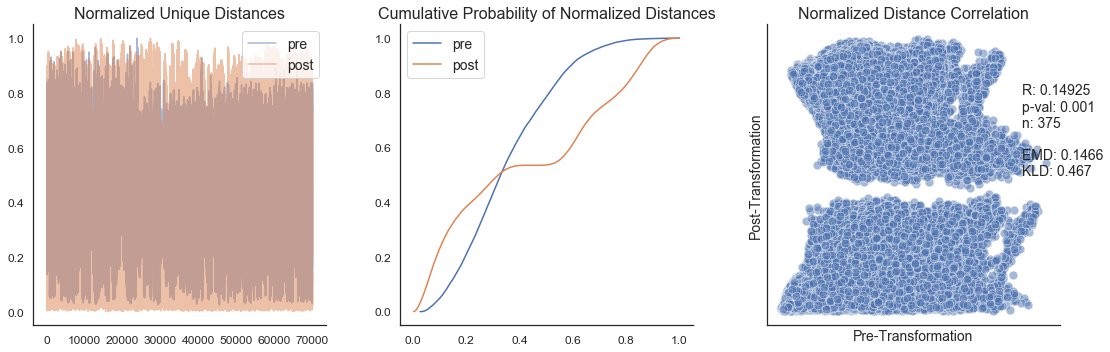

CPU times: user 4.16 s, sys: 185 ms, total: 4.35 s
Wall time: 3.73 s


In [123]:
%time mantel_stats, EMD, KLD = fcc_utils.compare_euclid(pre=r00_PCA, post=r00_umap) # compare distances for PCA to UMAP

---
TODO:
* Correlate clusters from one DR to another to determine if cells are ending up in the same clusters across methods
* Figure out how to determine when distance preservation is less important in favor of clustering